1. relation to mol
    - integral (e.g. polar surface area)
    - fragment (e.g. # carbonyl groups)
2. dimensionality
    - MW
    - 2D (wiener index)
    - 3D (mol volume)
3. proprietory
    - open source (rdkit)
    - commercial (alvaDesc)


In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors, rdMolDescriptors, GraphDescriptors
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
import copy
import numpy as np
import pandas as pd
import pickle

from rdkit.Chem.MolStandardize import rdMolStandardize

from IPython.display import Image
from IPython.display import SVG

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)

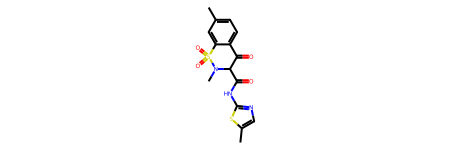

In [3]:
cox2_sdf = r'assets/COX2_inhibitors_final.sdf'
df = PandasTools.LoadSDF(cox2_sdf, molColName='Mol')
m0 = df['Mol'][0]
m0

In [4]:
# first submodule in rdkit - rdMolDescriptors
m_copy0 = copy.deepcopy(m0)
rdMolDescriptors.CalcNumAromaticRings(m_copy0)

2

In [5]:
# second submodule in rdkit - Descriptors
Descriptors.NumValenceElectrons(m_copy0)

126

In [6]:
# third submodule in rdkit - GraphDescriptors
GraphDescriptors.BalabanJ(m_copy0)

np.float64(2.0182561206423846)

In [7]:
# misc
m_copy0 = Chem.AddHs(m_copy0)
AllChem.Compute2DCoords(m_copy0)
AllChem.EmbedMolecule(m_copy0)
AllChem.ComputeMolVolume(m_copy0)

294.5040000000001

In [8]:
# standardisation problems
chloroethan_smi = 'CCCl'
mol_chloroethane = Chem.MolFromSmiles(chloroethan_smi)
rdMolDescriptors.CalcNumHBA(mol_chloroethane) # H-bond acceptors
# BUT it is not 0! chlorine should be able to act as a H-bond acceptor

0

In [9]:
# multicompounds, multiproperty descriptors
desc_bundles = []
desc_bundles.append(rdMolDescriptors.CalcNumAromaticRings(m_copy0))
desc_bundles.append(Descriptors.NumValenceElectrons(m_copy0))
desc_bundles.append(GraphDescriptors.BalabanJ(m_copy0))

m_copy0 = Chem.AddHs(m_copy0)
AllChem.Compute2DCoords(m_copy0)
AllChem.EmbedMolecule(m_copy0)
AllChem.ComputeMolVolume(m_copy0)
desc_bundles.append(AllChem.ComputeMolVolume(m_copy0))
desc_bundles

[2, 126, np.float64(2.4007034875528905), 296.4000000000001]

# MACCS

In [10]:
# maccs
import BitVector # conda install BitVector
from rdkit.Chem import MACCSkeys
maccs_desc = np.array(rdMolDescriptors.GetMACCSKeysFingerprint(m_copy0))
# print(type(np.where(maccs_desc == 1))) # tuple
ones_bits = list(np.where(maccs_desc == 1)[0])
# bv = BitVector.BitVector(bitlist = list(maccs_desc))
# bv
maccs_desc.shape

(167,)

In [11]:
len(MACCSkeys.smartsPatts)

166

The guy in neovarsity did it wrong! I think the first bit should not be mapped to anything, while the last bit should not be None

In [12]:
present_list = np.where(maccs_desc == 1)[0]
print(len(present_list))
# getting the indices of the maccs keys which is ==1 
l = list(map(MACCSkeys.smartsPatts.get, present_list)) # MACCSkeys.smartsPatts is a dict
print(len(l))
# ()'[#6]~[#16]~[#7]', NUMBER) means that if the pattern appears >NUMBER time, it is true. 

# turning into a df
# all_maccs_idx = list(range(1, 1+len(MACCSkeys.smartsPatts.keys())))
all_maccs_idx = list(range(1, 1+len(maccs_desc)))
# all_maccs_idx = list(MACCSkeys.smartsPatts.keys())
maccs_df = pd.DataFrame(maccs_desc)
maccs_df.index = list(map(MACCSkeys.smartsPatts.get, all_maccs_idx))
print(len(maccs_df))
print(len(list(map(MACCSkeys.smartsPatts.get, all_maccs_idx))))
print(len(MACCSkeys.smartsPatts))
maccs_df

67
67
167
167
166


,0
"(?, 0)",0
"([#104], 0)",0
"([#32,#33,#34,#50,#51,#52,#82,#83,#84], 0)",0
"([Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr], 0)",0
"([Sc,Ti,Y,Zr,Hf], 0)",0
...,...
"(*1~*~*~*~*~*~1, 0)",1
"([#8], 0)",1
"([R], 0)",1
"(?, 0)",1


In [13]:
# NOTE THAT THERE IS A NONE at the End
# This is because maccs tries to match the keys in smartpatts to the maccs_desc. so actually the first bit doesn't do anything

In [14]:
d = {
    1: ('?', 0),
    2: ('[#104]', 0),
    3: ('[#32,#33,#34,#50,#51,#52,#82,#83,#84]', 0)
    }
a = [0,1,2,3] # matching to index -- THE FIRST BIT SHOULD ALWAYS BE 0 FOR MACCS - https://forum.knime.com/t/rdkit-fingerprint-node-and-cdk-fingerprints-node-gives-different-maccs-keys/13149 



df = pd.DataFrame(a)
df.index = list(map(d.get, range(4))) # SHOULD NOT BE DOING WHATEVER WEIRD +1 thing the guy is doing
df

,0
None,0
"(?, 0)",1
"([#104], 0)",2
"([#32,#33,#34,#50,#51,#52,#82,#83,#84], 0)",3


## Semantic based fingerprint

- go to https://pubchem.ncbi.nlm.nih.gov/bioassay/1224848 
- download csv file. 
- modify csv file so that it does not have weird rows

/var/folders/zs/8v8rltc50nd745dlpz74pvrh0000gn/T/ipykernel_85957/2071319854.py:2: DtypeWarning: Columns (129,134,141,169,174,181,209,214,221,249,254,261,289,294,301,329,334,341,369,374,381,409,414,421,449,454,461,489,494,501,529,534,541,569,574,581,609,614,621,649,654,661,689,694,701,729,734,741,769,774,781,809,814,821,849,854,861,889,894,901,929,934,941,969,974,981,1009,1014,1021,1049,1054,1061,1089,1094,1101,1129,1134,1141,1169,1174,1181,1209,1214,1221,1249,1254,1261,1289,1294,1301,1329,1334,1341,1369,1374,1381,1409,1414,1421,1449,1454,1461,1489,1494,1501,1529,1534,1541,1569,1574,1581,1609,1614,1621,1649,1654,1661,1689,1694,1701,1729,1734,1741,1769,1774,1781,1809,1814,1821,1849,1854,1861,1889,1894,1901,1929,1934,1941,1969,1974,1981,2009,2014,2021) have mixed types. Specify dtype option on import or set low_memory=False.
  estrogen_related_receptor_antogonist = pd.read_csv(tox21_qhts_path)


Index(['PUBCHEM_RESULT_TAG', 'PUBCHEM_SID', 'PUBCHEM_CID',
       'PUBCHEM_EXT_DATASOURCE_SMILES', 'PUBCHEM_ACTIVITY_OUTCOME',
       'PUBCHEM_ACTIVITY_SCORE', 'PUBCHEM_ACTIVITY_URL',
       'PUBCHEM_ASSAYDATA_COMMENT', 'Phenotype-Replicate_1',
       'Potency-Replicate_1',
       ...
       'Activity at 18.95 uM-Replicate_51',
       'Activity at 42.46 uM-Replicate_51',
       'Activity at 92.41 uM-Replicate_51',
       'Activity at 240.3 uM-Replicate_51',
       'Activity at 872.4 uM-Replicate_51',
       'Activity at 1849.0 uM-Replicate_51',
       'Activity at 4135.0 uM-Replicate_51',
       'Activity at 9246.0 uM-Replicate_51',
       'Activity at 20670.0 uM-Replicate_51',
       'Activity at 46230.0 uM-Replicate_51'],
      dtype='object', length=2049)


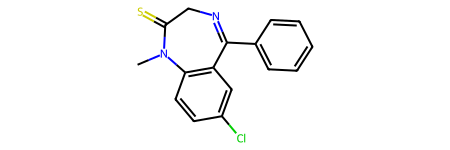

In [15]:
tox21_qhts_path = r"assets/AID_1224848_datatable_modified.csv"
estrogen_related_receptor_antogonist = pd.read_csv(tox21_qhts_path)
print(estrogen_related_receptor_antogonist.columns)
estrogen_related_receptor_antogonist_clean = estrogen_related_receptor_antogonist.dropna(subset=['PUBCHEM_EXT_DATASOURCE_SMILES'])
mol_list = [Chem.MolFromSmiles(smi) for smi in estrogen_related_receptor_antogonist_clean['PUBCHEM_EXT_DATASOURCE_SMILES']]
mol_list[0]

In [16]:
print(np.unique(estrogen_related_receptor_antogonist_clean['PUBCHEM_ACTIVITY_OUTCOME']))
# remove inconclusive results
print(len(estrogen_related_receptor_antogonist_clean))
estrogen_related_receptor_antogonist_clean_noinconclusive = copy.deepcopy(estrogen_related_receptor_antogonist_clean.loc[estrogen_related_receptor_antogonist_clean['PUBCHEM_ACTIVITY_OUTCOME'] != 'Inconclusive'])
print(len(estrogen_related_receptor_antogonist_clean_noinconclusive))
print(list(estrogen_related_receptor_antogonist_clean.columns[:30]))

['Active' 'Inactive' 'Inconclusive']
9522
8667
['PUBCHEM_RESULT_TAG', 'PUBCHEM_SID', 'PUBCHEM_CID', 'PUBCHEM_EXT_DATASOURCE_SMILES', 'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE', 'PUBCHEM_ACTIVITY_URL', 'PUBCHEM_ASSAYDATA_COMMENT', 'Phenotype-Replicate_1', 'Potency-Replicate_1', 'Efficacy-Replicate_1', 'Analysis Comment-Replicate_1', 'Activity_Score-Replicate_1', 'Curve_Description-Replicate_1', 'Fit_LogAC50-Replicate_1', 'Fit_HillSlope-Replicate_1', 'Fit_R2-Replicate_1', 'Fit_InfiniteActivity-Replicate_1', 'Fit_ZeroActivity-Replicate_1', 'Fit_CurveClass-Replicate_1', 'Excluded_Points-Replicate_1', 'Max_Response-Replicate_1', 'Activity at 0.0000060039 uM-Replicate_1', 'Activity at 0.0000137707 uM-Replicate_1', 'Activity at 0.0000545120 uM-Replicate_1', 'Activity at 0.0001296300 uM-Replicate_1', 'Activity at 0.0003002588 uM-Replicate_1', 'Activity at 0.0006197232 uM-Replicate_1', 'Activity at 0.00170 uM-Replicate_1', 'Activity at 0.00522 uM-Replicate_1']


In [17]:
# estrogen_related_receptor_antogonist_clean_noinconclusive['PUBCHEM_ACTIVITY_SCORE']
estrogen_related_receptor_antogonist_clean_noinconclusive.describe()

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ASSAYDATA_COMMENT,Potency-Replicate_1,Efficacy-Replicate_1,Analysis Comment-Replicate_1,Activity_Score-Replicate_1,Fit_LogAC50-Replicate_1,...,Activity at 18.95 uM-Replicate_51,Activity at 42.46 uM-Replicate_51,Activity at 92.41 uM-Replicate_51,Activity at 240.3 uM-Replicate_51,Activity at 872.4 uM-Replicate_51,Activity at 1849.0 uM-Replicate_51,Activity at 4135.0 uM-Replicate_51,Activity at 9246.0 uM-Replicate_51,Activity at 20670.0 uM-Replicate_51,Activity at 46230.0 uM-Replicate_51
count,8667.000000,8.667000e+03,8.667000e+03,8667.000000,0.0,1758.000000,1758.000000,0.0,8667.000000,5350.000000,...,18.000000,18.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,4839.775932,1.544132e+08,3.719843e+06,8.646821,NaN,30.782330,101.270710,NaN,8.646821,-5.234019,...,4.015583,3.683639,5.931661,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2803.022750,2.213114e+07,1.486420e+07,22.207256,NaN,267.766047,50.693578,NaN,22.207256,1.220537,...,47.279303,51.303823,45.357903,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.442055e+08,4.000000e+00,0.000000,NaN,0.001900,30.000000,NaN,0.000000,-9.949300,...,-85.148200,-105.385000,-118.955000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2373.500000,1.442094e+08,7.650500e+03,0.000000,NaN,7.497800,71.377850,NaN,0.000000,-5.513700,...,-3.998250,-2.833925,-0.586900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4867.000000,1.442119e+08,2.008700e+04,0.000000,NaN,21.678900,93.998700,NaN,0.000000,-4.763700,...,-0.327000,0.688650,1.207450,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7273.500000,1.704649e+08,1.275740e+05,0.000000,NaN,32.520150,120.362500,NaN,0.000000,-4.463700,...,3.349050,5.516600,13.912625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,9666.000000,2.519200e+08,1.666423e+08,99.000000,NaN,11220.200000,461.822000,NaN,99.000000,-1.950000,...,169.346000,169.969000,132.419000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Typically we want to also remove weak compounds (compounds which are not very active)
- should also look at toxicity -- drugs should not be toxic

## CAPSTONE

- create python code that captures a molecule's capacity to be a halogen bond donor
- use code to calculate the property for the dataset
- filter out compounds that do not have the halogen bond Halogen bond is a bond between two non-covelently bound atoms, where donor has a positively charged sigma hole, and acceptor is a ILewis base. The view on what a good halogen donor group is can vary, one of the accepted definitions is a halogen atom that is not fluorine, since fluorine sigma hole is neutralized. [from Journal of Molecular Modeling volume 13, pages291-296 (2007)]

In [18]:
import rdkit as rd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import copy
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit. Chem import GraphDescriptors
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
import numpy as np
import pandas as pd
import pickle

In [19]:
# Function to check if a molecule has a halogen bond donor
def has_halogen_bond_donor(mol):
    """
    Check if a molecule has a halogen atom (Cl, Br, I) that can act as a halogen bond donor.
    """
    halogen_atoms = ['Cl', 'Br', 'I']
    for atom in mol.GetAtoms():
        if atom.GetSymbol() in halogen_atoms:
            return True
    return False

# Function to calculate the halogen bond donor property for a dataset
def calculate_halogen_bond_donor_property(dataset):
    """
    Calculate the halogen bond donor property for a dataset of molecules.
    """
    dataset['HalogenBondDonor'] = dataset['Mol'].apply(has_halogen_bond_donor)
    return dataset

# Function to filter out compounds that do not have the halogen bond donor property
def filter_halogen_bond_donors(dataset):
    """
    Filter out compounds that do not have the halogen bond donor property.
    """
    filtered_dataset = dataset[dataset['HalogenBondDonor']]
    return filtered_dataset

In [20]:
cox2_sdf = r'assets/COX2_inhibitors_final.sdf'
df = PandasTools.LoadSDF(cox2_sdf, molColName='Mol')
df[:1]

,SMILES,CHEMBLID,"Inhibition, %",ID,Mol
0,CN1C(C(=O)Nc2ncc(C)s2)C(=O)c2ccc(C)cc2S1(=O)=O,CHEMBL366429,35,CHEMBL366429,<rdkit.Chem.rdchem.Mol object at 0x137d480b0>


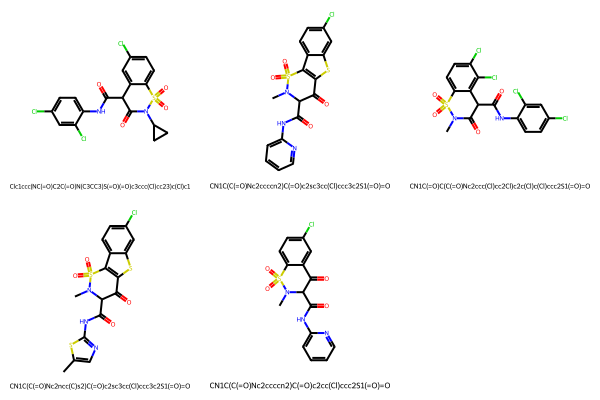

In [21]:
# has_halogen_bond_donor(df["Mol"][0])
df = calculate_halogen_bond_donor_property(df)
filtered_dataset = filter_halogen_bond_donors(df)

Draw.MolsToGridImage(filtered_dataset['Mol'].iloc[:5], legends=filtered_dataset['SMILES'].iloc[:5].tolist())


In [24]:
df.to_csv(r"/Users/marcusc/Documents/Courses/neovarsity_chemoinformatics_2024/assets/chap8_output_halogen.csv")